In [46]:
import bz2
import json

path = r"C:\Users\rusha\tactical_viewer\Tracking Data\3812.jsonl.bz2"

frames = []

with bz2.open(path, "rt", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 2000:   # ~80 seconds of play
            break
        frames.append(json.loads(line))

len(frames)

2000

In [47]:
import pandas as pd

rows = []

for frame in frames:
    frame_num = frame["frameNum"]
    period = frame["period"]

    for p in frame["homePlayers"]:
        rows.append({
            "frame": frame_num,
            "period": period,
            "team": "home",
            "jersey": p["jerseyNum"],
            "visibility": p["visibility"],
            "x": p["x"],
            "y": p["y"],
        })

    for p in frame["awayPlayers"]:
        rows.append({
            "frame": frame_num,
            "period": period,
            "team": "away",
            "jersey": p["jerseyNum"],
            "visibility": p["visibility"],
            "x": p["x"],
            "y": p["y"],
        })

df = pd.DataFrame(rows)
df.head()

,frame,period,team,jersey,visibility,x,y
0,4226,1,home,21,VISIBLE,13.975,19.244
1,4226,1,home,4,VISIBLE,8.035,6.507
2,4226,1,home,16,ESTIMATED,41.257,-0.454
3,4226,1,home,6,VISIBLE,9.283,-0.842
4,4226,1,home,22,VISIBLE,17.438,-22.039


In [48]:
players_per_frame = (
    df.groupby(["frame", "team"])["jersey"]
      .nunique()
      .reset_index(name="n_players")
)

players_per_frame.head()


,frame,team,n_players
0,4226,away,11
1,4226,home,11
2,4227,away,11
3,4227,home,11
4,4228,away,11


In [49]:
player_presence = (
    df.groupby(["team", "jersey"])
      .agg(
          first_frame=("frame", "min"),
          last_frame=("frame", "max"),
          n_frames=("frame", "count"),
      )
      .reset_index()
)

player_presence.sort_values("first_frame").head()

,team,jersey,first_frame,last_frame,n_frames
0,away,11,4226,6210,2000
19,home,6,4226,6210,2000
18,home,5,4226,6210,2000
17,home,4,4226,6210,2000
16,home,3,4226,6210,2000


In [50]:
df = df.sort_values(["team", "jersey", "frame"])

df["frame_gap"] = (
    df.groupby(["team", "jersey"])["frame"]
      .diff()
)

df[df["frame_gap"] > 1].head(10)

,frame,period,team,jersey,visibility,x,y,frame_gap


In [51]:
import numpy as np

df["dx"] = df.groupby(["team", "jersey"])["x"].diff()
df["dy"] = df.groupby(["team", "jersey"])["y"].diff()

df["distance"] = np.sqrt(df["dx"]**2 + df["dy"]**2)

FPS = 25
df["speed_mps"] = df["distance"] * FPS

df[df["speed_mps"] > 10].head()

,frame,period,team,jersey,visibility,x,y,frame_gap,dx,dy,distance,speed_mps
21292,5193,1,away,11,VISIBLE,-14.420,14.466,1.0,-0.294,0.358,0.463249,11.581235
21644,5209,1,away,11,VISIBLE,-14.834,14.140,1.0,0.019,-0.453,0.453398,11.334957
22634,5254,1,away,11,VISIBLE,-16.319,11.301,1.0,-0.031,-0.542,0.542886,13.572145
27210,5462,1,away,11,VISIBLE,-16.192,-16.653,1.0,-0.835,-0.405,0.928036,23.200889
27562,5478,1,away,11,VISIBLE,-18.115,-17.339,1.0,-0.540,-0.236,0.589318,14.732956


In [52]:
def player_state(row):
    if row["visibility"] == "VISIBLE":
        return "ON_PITCH_VISIBLE"
    elif row["visibility"] == "ESTIMATED":
        return "ON_PITCH_ESTIMATED"
    else:
        return "UNKNOWN"

In [53]:
df["player_state"] = df.apply(player_state, axis=1)

In [54]:
df["player_state"].value_counts()

player_state
ON_PITCH_VISIBLE      26112
ON_PITCH_ESTIMATED    17888
Name: count, dtype: int64

In [55]:
df["interpolation_ok"] = (
    (df["player_state"] == "ON_PITCH_VISIBLE") &
    (df["frame_gap"].fillna(1) <= 10)
)

In [56]:
player_summary = (
    df.groupby(["team", "jersey"])
      .agg(
          frames_total=("frame", "count"),
          visible_frames=("player_state", lambda x: (x == "ON_PITCH_VISIBLE").sum()),
          estimated_frames=("player_state", lambda x: (x == "ON_PITCH_ESTIMATED").sum()),
          first_frame=("frame", "min"),
          last_frame=("frame", "max"),
      )
      .reset_index()
)

player_summary.head()

,team,jersey,frames_total,visible_frames,estimated_frames,first_frame,last_frame
0,away,11,2000,1407,593,4226,6210
1,away,17,2000,1226,774,4226,6210
2,away,18,2000,1179,821,4226,6210
3,away,21,2000,1379,621,4226,6210
4,away,22,2000,1341,659,4226,6210


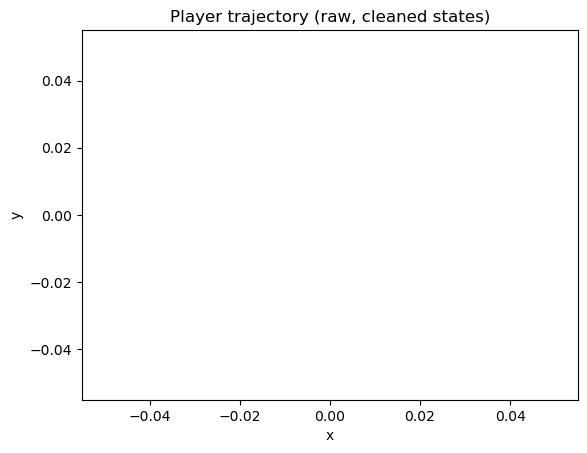

In [57]:
import matplotlib.pyplot as plt

example = df[(df["team"] == "home") & (df["jersey"] == df["jersey"].iloc[0])]

plt.plot(example["x"], example["y"], alpha=0.7)
plt.title("Player trajectory (raw, cleaned states)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()